## Imports

In [1]:
import torch
import pandas as pd
import os
from torchvision import transforms
from EmotionDataset import EmotionDataset, get_transform
from EmotionCNN import EmotionCNN
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomAdjustSharpness,
    ToTensor
)

## Data Preprocessing

In [2]:
# Load and prepare the dataset
dataset_path = os.path.join(os.getcwd(), 'data')
labels_path = os.path.join(dataset_path, 'labels.csv')
df = pd.read_csv(labels_path)

df['label'] = df['pth'].apply(lambda x: x.split('/')[0])
label_to_int = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_to_int)
df['pth'] = df['pth'].apply(lambda x: os.path.join(dataset_path, x))
df = df[['pth', 'label']]  # Only use path and integer label

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
print(df.head())

                                                 pth  label
0  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      2
1  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      0
2  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      3
3  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      2
4  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      3


### Class Distributions

In [4]:
print("Training set class distribution:")
print(train_df.iloc[:, 1:].sum())

print("\nTesting set class distribution:")
print(test_df.iloc[:, 1:].sum())

Training set class distribution:
label    85722
dtype: int64

Testing set class distribution:
label    21631
dtype: int64


In [5]:
# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Calculate class weights
class_counts = train_df.iloc[:, 1:].sum().values
total_counts = sum(class_counts)
class_weights = [total_counts / count for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

In [7]:
# Transform for first epoch
transform_initial = get_transform()

# Augment training data for epochs after first
transform_augmented = transforms.Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    RandomAdjustSharpness(2),
    transforms.Resize((96, 96)),
    ToTensor()
])

In [8]:
# Create the datasets
train_dataset = EmotionDataset(train_df, transform_initial)
test_dataset = EmotionDataset(test_df, get_transform())

In [9]:
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [10]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, 1)
    return (predictions == labels).float().mean().item()

## Model Training

In [12]:
# Lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

# Variables to store the best model
best_test_accuracy = 0.0
best_model_path = './models/best_model'
best_epoch = 0

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # Update the transform after the first epoch
    if epoch > 0:
        train_dataset.transform = transform_augmented
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Save training loss
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluate on training set
    model.eval()
    train_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            train_accuracy += calculate_accuracy(outputs, labels)
    train_accuracy /= len(train_loader)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on testing set
    test_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_accuracy += calculate_accuracy(outputs, labels)
    test_accuracy /= len(test_loader)
    test_accuracies.append(test_accuracy)
    
    # Check if this is the best model so far
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, '
          f'Training Accuracy: {train_accuracies[-1]:.4f}, Testing Accuracy: {test_accuracies[-1]:.4f}')

Epoch [1/15], Loss: 1.4393, Training Accuracy: 0.5444, Testing Accuracy: 0.5269


## Model Evaluation

### Loss and Accuracy

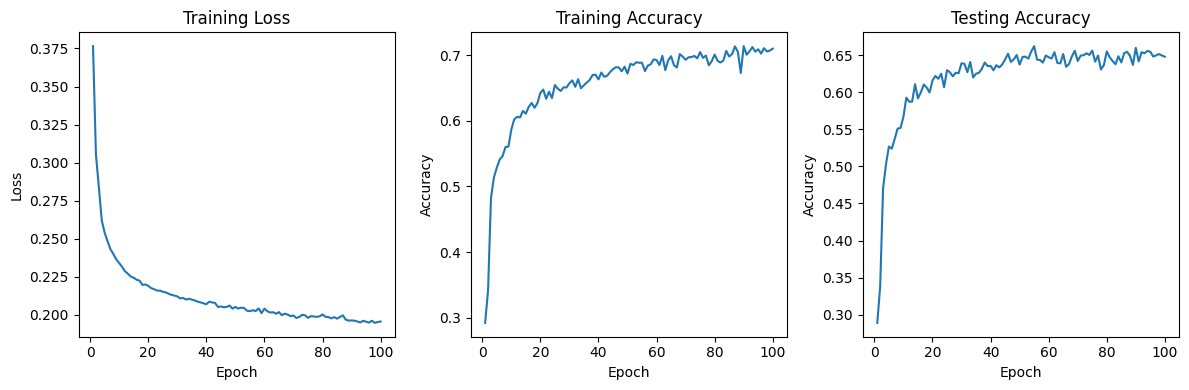

In [ ]:
# Plot model evaluation
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.axvline(x=best_epoch+1, color='r', linestyle='--', label='Best Model')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.axvline(x=best_epoch+1, color='r', linestyle='--', label='Best Model')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.axvline(x=best_epoch+1, color='r', linestyle='--', label='Best Model')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save model
#torch.save(model, './models/emotionModel4')

In [ ]:
# Load model
model_path = './models/best_model'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

In [ ]:
# Get the list of class names from the columns
class_names = list(label_to_int.keys())

# Evaluate on testing set and get predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate precision, recall, f1 score
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(all_labels, all_predictions)

### More Evaluation Metrics

In [ ]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6380
Recall: 0.1549
F1 Score: 0.0901


### Classification Report

In [ ]:
# Get the list of class names from the columns
class_names = list(df.columns[1:])

# Print classification report for detailed insights
print(classification_report(all_labels, all_predictions, target_names=class_names, zero_division=1))

              precision    recall  f1-score   support

       anger       1.00      0.00      0.00       587
    contempt       1.00      0.00      0.00       541
     disgust       1.00      0.00      0.00       462
        fear       1.00      0.00      0.00       607
       happy       0.20      0.50      0.29      1027
     neutral       1.00      0.00      0.00      1025
         sad       0.11      0.42      0.18       590
    surprise       0.12      0.15      0.14       796

    accuracy                           0.15      5635
   macro avg       0.68      0.13      0.08      5635
weighted avg       0.64      0.15      0.09      5635



### Confusion Matrix

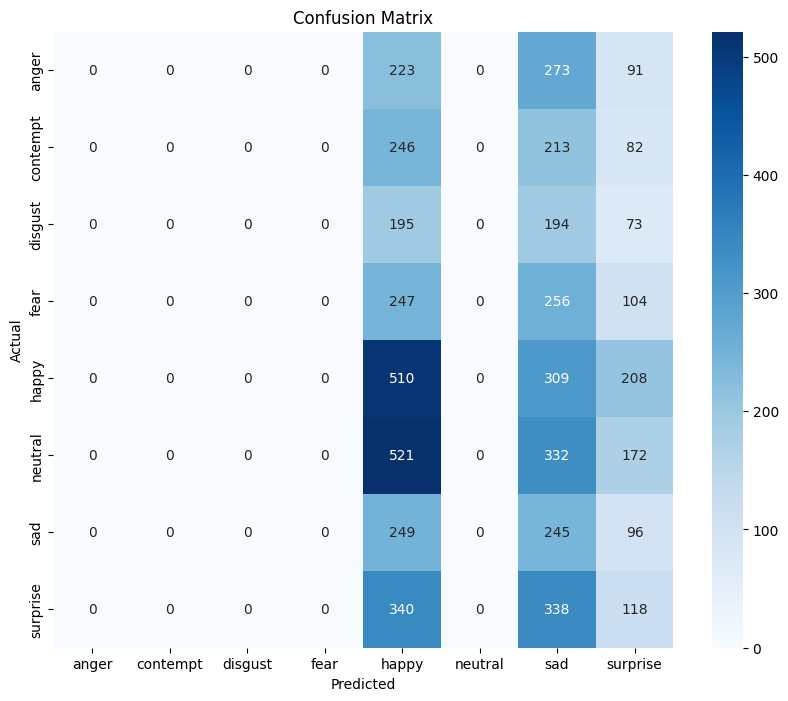

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Check class distribution in training and testing sets
print("Training set class distribution:")
print(train_df.iloc[:, 1:].sum())

print("\nTesting set class distribution:")
print(test_df.iloc[:, 1:].sum())

Training set class distribution:
anger       2447
contempt    2216
disgust     1915
fear        2372
happy       4016
neutral     4089
sad         2344
surprise    3141
dtype: int64

Testing set class distribution:
anger        587
contempt     541
disgust      462
fear         607
happy       1027
neutral     1025
sad          590
surprise     796
dtype: int64
